In [2]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
# from wpca import WPCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world
from aquabyte.visualize import Visualizer
import random
import pickle
from scipy.stats import norm

pd.set_option('display.max_rows', 500)

<h1> Extract base data from database </h1>

In [3]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null
    and (b.is_qa = false or b.captured_at > '2019-09-19');
"""
df = rds_access_utils.extract_from_database(query)

<h1> Append world kepyoints to the data </h1>
<h3> Ideally, this data should already live directly in the database </h3>

In [4]:
def get_world_keypoints(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    else:
        return None
    
df['world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


<h1> Compute centroid depth </h1>

In [5]:
def centroid_depth(x):
    if x:
        return np.mean([w[1] for w in x.values()])
    return None

df['depth'] = df.world_keypoints.apply(lambda x: centroid_depth(x))

<h1> Get the features dataframe from the base data with all pairwise distances </h1>

In [6]:
features_data = defaultdict(list)

body_parts = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE',
    'UPPER_PRECAUDAL_PIT', 
    'LOWER_PRECAUDAL_PIT',
    'HYPURAL_PLATE'
])

for idx, row in df.iterrows():
    world_keypoints = row.world_keypoints
    if world_keypoints:
        for i in range(len(body_parts)-1):
            for j in range(i+1, len(body_parts)):
                d = euclidean_distance(world_keypoints[body_parts[i]], 
                                       world_keypoints[body_parts[j]])
                features_data['{0}-{1}'.format(i, j)].append(d)

        features_data['weight'].append(row.weight)
        features_data['captured_at'].append(row.captured_at)
        features_data['gtsf_fish_identifier'].append(row.fish_id)
        features_data['pen_id'].append(row.pen_id)
        features_data['keypoint_annotation_id'].append(row.id)
        features_data['world_keypoints'].append(row.world_keypoints)
        features_data['depth'].append(row.depth)
        features_data['kf'].append(1e5 * row.weight / row['data']['lengthMms']**3) 
        features_data['length'].append(row['data']['lengthMms'] * 1e-3)
        features_data['breadth'].append(row['data']['breadthMms'] * 1e-3 if 'breadhMms' in row['data'] else None)

features_df = pd.DataFrame(features_data)

# get rid of bad keypoint annotation ids

blacklisted_keypoint_annotation_ids = [
    606484, 
    635806, 
    637801, 
    508773, 
    640493, 
    639409, 
    648536, 
    507003,
    706002,
    507000,
    709298,
    714073,
    719239
]

blacklist_mask = features_df['8-9'] > 1.0
for kp_id in blacklisted_keypoint_annotation_ids:
    if blacklist_mask is None:
        blacklist_mask = features_df.keypoint_annotation_id == kp_id
    else:
        blacklist_mask = blacklist_mask | (features_df.keypoint_annotation_id == kp_id)
features_df = features_df[~blacklist_mask]



/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:4: RuntimeWarning: invalid value encountered in subtract
  return np.linalg.norm(np.array(p1) - np.array(p2))


In [7]:
# define all features

body_parts_subset = sorted([
    'HYPURAL_PLATE',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE'
])

body_part_indices = [body_parts.index(bp) for bp in body_parts_subset]

pairwise_distance_columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(body_part_indices, 2))]
interaction_columns_quadratic = []
interaction_columns_cubic = []
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        col1 = pairwise_distance_columns[i]
        col2 = pairwise_distance_columns[j]
        interaction_column = '{},{}'.format(col1, col2)
        features_df[interaction_column] = features_df[col1] * features_df[col2]
        interaction_columns_quadratic.append(interaction_column)
        
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        for k in range(j, len(pairwise_distance_columns)):
            col1 = pairwise_distance_columns[i]
            col2 = pairwise_distance_columns[j]
            col3 = pairwise_distance_columns[k]
            interaction_column = '{},{},{}'.format(col1, col2, col3)
            features_df[interaction_column] = features_df[col1] * features_df[col2] * features_df[col3]
            interaction_columns_cubic.append(interaction_column)
            

<h1> Weight each datapoint based on the number of stereo images captured for that fish </h1>

In [8]:
weights = []
i = 0
for idx, row in features_df.iterrows():
    if i % 100 == 0:
        print(i)
    i += 1
    count = features_df[features_df.gtsf_fish_identifier == row.gtsf_fish_identifier].shape[0]
    if count > 1:
        weights.append(1.0 / count ** 0.5)
#         weights.append(1.0 / count)
    else:
        weights.append(1)
        
features_df['w'] = weights

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800


<h1> Model Training </h1>

In [9]:
def generate_train_mask(df, train_frac, randomize=True):
    x = np.zeros((df.shape[0]), dtype=bool)
    x[:int(train_frac * df.shape[0])] = True
    np.random.shuffle(x)
    mask = pd.Series(x)
    return x
    

def generate_oos_score(features_df, mask, train_size, num_eigenvectors):
    np.random.seed(0)
    columns = pairwise_distance_columns + interaction_columns_quadratic + interaction_columns_cubic

    X_train = features_df.loc[mask, columns].values
    y_train = features_df.loc[mask, 'weight'].values
    w_train = features_df.loc[mask, 'w'].values
    X_test = features_df.loc[~mask, columns].values
    y_test = features_df.loc[~mask, 'weight'].values

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)

    pca = PCA(n_components=min(X_train_normalized.shape[0], X_train_normalized.shape[1]))
    pca.fit(X_train_normalized)
    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    idx = num_eigenvectors

    pca = PCA(n_components=idx+1)
    pca.fit(X_train_normalized)
    X_train_transformed = pca.transform(X_train_normalized)
    X_test_normalized = scaler.transform(X_test)
    X_test_transformed = pca.transform(X_test_normalized)

    reg = LinearRegression().fit(X_train_transformed, y_train, sample_weight=w_train)
    score = reg.score(X_test_transformed, y_test)

    y_pred = reg.predict(pca.transform(scaler.transform(features_df[columns].values)))
    features_df['prediction'] = y_pred
    features_df['error'] = features_df.prediction - features_df.weight
    features_df['error_pct'] = features_df.error / features_df.weight
    features_df['abs_error_pct'] = features_df.error_pct.abs()

    model = {
    'mean': scaler.mean_,
    'std': scaler.scale_,
    'PCA_components': pca.components_,
    'reg_coef': reg.coef_,
    'reg_intercept': reg.intercept_,
    'body_parts': body_parts_subset   
    }
    

    return mask, model, score



<h1> Plot one instance of train / test where the training set consists of 2000 fish </h1>

In [55]:
features_df[features_df.captured_at < '2019-07-15'].shape[0] / features_df.shape[0]

0.4826782564877803

In [56]:
# num eigenvectors = 20

train_size = 2000
gtsf_fish_identifiers = list(features_df.gtsf_fish_identifier.unique())
fish_ids = random.sample(gtsf_fish_identifiers, train_size)
data_mask = (features_df.captured_at < '2019-07-15') 
mask = data_mask
mask, model, score = generate_oos_score(features_df, mask, 2000, 20)

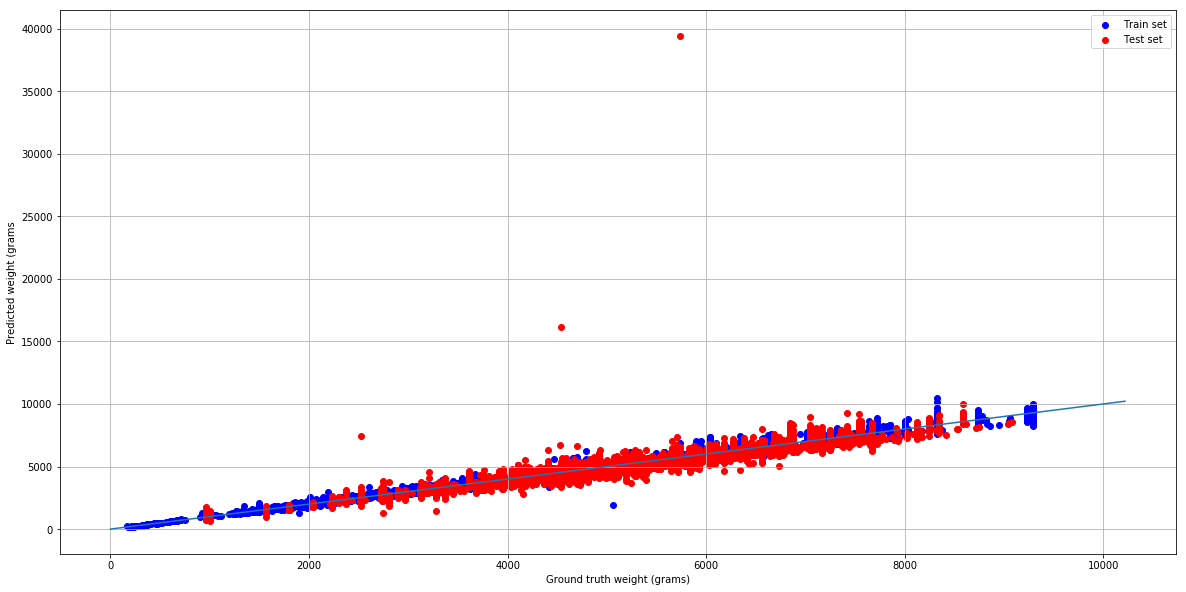

In [59]:
%matplotlib inline
amg = AccuracyMetricsGenerator()
test_mask = ~mask & (features_df.captured_at < '2019-09-10')
amg.set_data(mask, features_df.prediction.values, features_df.weight.values, w=features_df.w.values, test_mask=test_mask)
amg.plot_predictions_vs_ground_truth(impose_bounds=False)

In [29]:
pickle.dump(model, open('/root/data/alok/biomass_estimation/playground/linear_pca_model.pkl', 'wb'))

In [60]:
amg.display_train_test_accuracy_metrics()

=============== TRAIN SET METRICS ===============
avg_per_fish_abs_err: 139.761
avg_per_fish_abs_pct_err: 0.038205
avg_per_fish_err: 6.4542e-12
avg_per_fish_pct_err: 0.002507
biomass_err: 6.3665e-12
biomass_error_pct: 1.5813e-15
median_per_fish_abs_err: 97.613
median_per_fish_abs_pct_err: 0.028874
median_per_fish_err: 2.009
median_per_fish_pct_err: 0.00077676
std_per_fish_pct_err: 0.054662

=============== TEST SET METRICS ===============
avg_per_fish_abs_err: 309.206
avg_per_fish_abs_pct_err: 0.061231
avg_per_fish_err: -172.84
avg_per_fish_pct_err: -0.03332
biomass_err: -172.84
biomass_error_pct: -0.03359
median_per_fish_abs_err: 265.42
median_per_fish_abs_pct_err: 0.053765
median_per_fish_err: -199.81
median_per_fish_pct_err: -0.041829
std_per_fish_pct_err: 0.095421


<h1> Display Accuracy by Depth </h1>

In [78]:
tdf = features_df.sort_values('captured_at', ascending=True)
tdf['difference'] = tdf['8-9'] - tdf.length

In [84]:
idx_values = list(np.arange(0, tdf.shape[0], 1000))
mean_diffs = []
for k in range(len(idx_values)-1):
    lower_idx, upper_idx = idx_values[k], idx_values[k+1]
    mean_diff = tdf[(tdf.index >= lower_idx) & (tdf.index <= upper_idx)].difference.mean()
    mean_diffs.append(mean_diff)
    print(lower_idx, mean_diff)
    
    

0 -0.009919899610518436
1000 -0.024923001910399964
2000 -0.009601137259499336
3000 -0.02379240139141337
4000 -0.008971183476973727
5000 -0.023458538989367006
6000 -0.009026972250162362
7000 -0.023585407047231253
8000 -0.008716692779736523
9000 -0.023569910518006772
10000 -0.00937987972205884
11000 -0.023912435816022228
12000 -0.009409592055730734
13000 -0.02621454568627294
14000 -0.009344147159969033


In [85]:
tdf.index = pd.to_datetime(tdf.captured_at)

In [91]:
tdf.difference.resample('D', how=lambda x: np.mean(x))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


captured_at
2019-03-01 00:00:00+00:00   -0.018649
2019-03-02 00:00:00+00:00         NaN
2019-03-03 00:00:00+00:00         NaN
2019-03-04 00:00:00+00:00   -0.018358
2019-03-05 00:00:00+00:00   -0.007674
2019-03-06 00:00:00+00:00   -0.009110
2019-03-07 00:00:00+00:00         NaN
2019-03-08 00:00:00+00:00         NaN
2019-03-09 00:00:00+00:00         NaN
2019-03-10 00:00:00+00:00         NaN
2019-03-11 00:00:00+00:00   -0.011761
2019-03-12 00:00:00+00:00         NaN
2019-03-13 00:00:00+00:00   -0.015117
2019-03-14 00:00:00+00:00   -0.010310
2019-03-15 00:00:00+00:00         NaN
2019-03-16 00:00:00+00:00         NaN
2019-03-17 00:00:00+00:00         NaN
2019-03-18 00:00:00+00:00   -0.005109
2019-03-19 00:00:00+00:00   -0.006603
2019-03-20 00:00:00+00:00         NaN
2019-03-21 00:00:00+00:00    0.004774
2019-03-22 00:00:00+00:00         NaN
2019-03-23 00:00:00+00:00         NaN
2019-03-24 00:00:00+00:00         NaN
2019-03-25 00:00:00+00:00   -0.001454
2019-03-26 00:00:00+00:00         NaN


In [61]:
features_df.length

0        0.815
1        0.809
2        0.845
3        0.801
4        0.865
         ...  
15942    0.784
15943    0.814
15944    0.706
15945    0.807
15946    0.779
Name: length, Length: 15876, dtype: float64

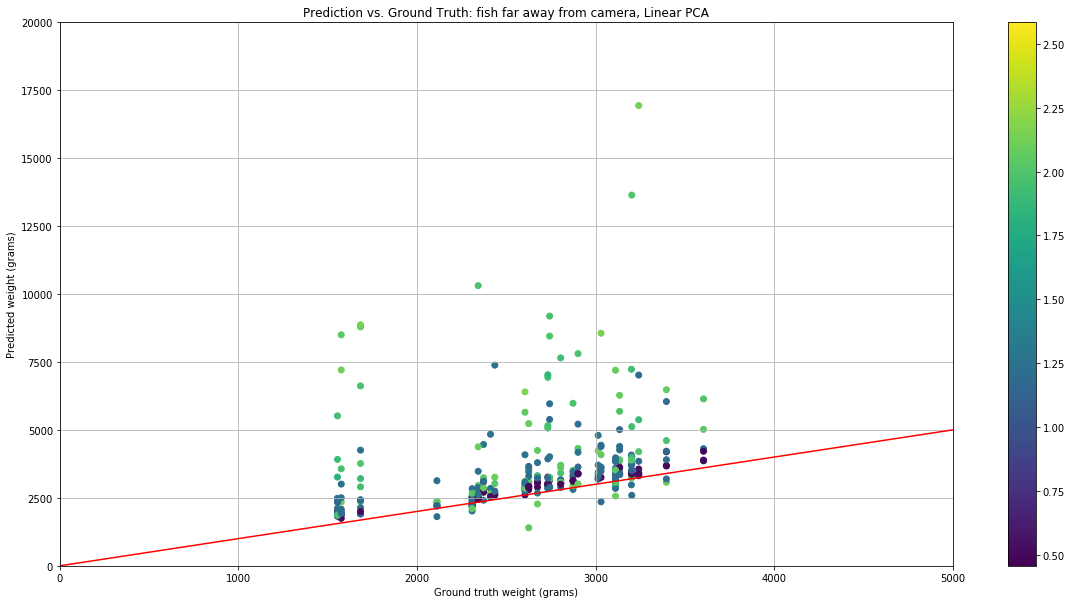

In [31]:
%matplotlib inline
mask = features_df.captured_at < '2019-09-10'
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(features_df[~mask].weight.values, features_df[~mask].prediction.values, c=features_df[~mask].depth.values)
plt.colorbar(sc)
plt.plot([0, 5e3], [0, 5e3], color='red')
plt.xlim([0, 5e3])
plt.ylim([0, 2e4])
plt.xlabel('Ground truth weight (grams)')
plt.ylabel('Predicted weight (grams)')
plt.title('Prediction vs. Ground Truth: fish far away from camera, Linear PCA')
plt.grid()
plt.show()

In [37]:
np.std(np.abs((features_df[~mask].prediction.values - features_df[~mask].weight.values)/features_df[~mask].weight.values))




0.8334306656366677

In [36]:
(features_df[~mask].prediction.values.mean() - features_df[~mask].weight.values.mean()) / features_df[~mask].weight.values.mean()

0.39928835103589855

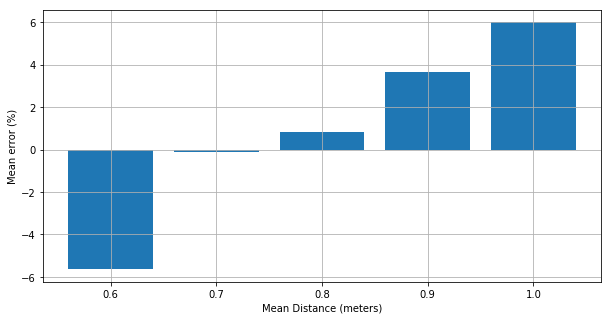

In [213]:
depths = [round(x, 1) for x in list(np.arange(0.6, 1.2, 0.1))]
error_pcts = []
for idx in range(len(depths)-1):
    mask = (features_df.captured_at >= '2019-09-06') & (features_df.depth > depths[idx]) & (features_df.depth < depths[idx+1])
    mean_prediction = features_df[mask].prediction.mean()
    mean_ground_truth = features_df[mask].weight.mean()
    error_pct = (mean_prediction - mean_ground_truth) / mean_ground_truth
    error_pcts.append(error_pct)
    


plt.figure(figsize=(10, 5))
ind = list(range(len(depths[:-1])))
plt.bar(ind, np.array(error_pcts) * 1e2)
plt.xticks(ind, depths[:-1])
plt.xlabel('Mean Distance (meters)')
plt.ylabel('Mean error (%)')
plt.grid()
plt.show()

In [185]:
list(range(depths[:-1]))

TypeError: 'list' object cannot be interpreted as an integer

<h1> Visualize some cases </h1>

In [65]:
s3_access_utils = S3AccessUtils('/root/data')
credentials = json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS']))
rds_access_utils = RDSAccessUtils(credentials)
v = Visualizer(s3_access_utils, rds_access_utils)


Exception during reset or similar
Traceback (most recent call last):
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.do_rollback(self)
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 530, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index frames_captured_at_date
  "expression-based index %s" % idx_name
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/p

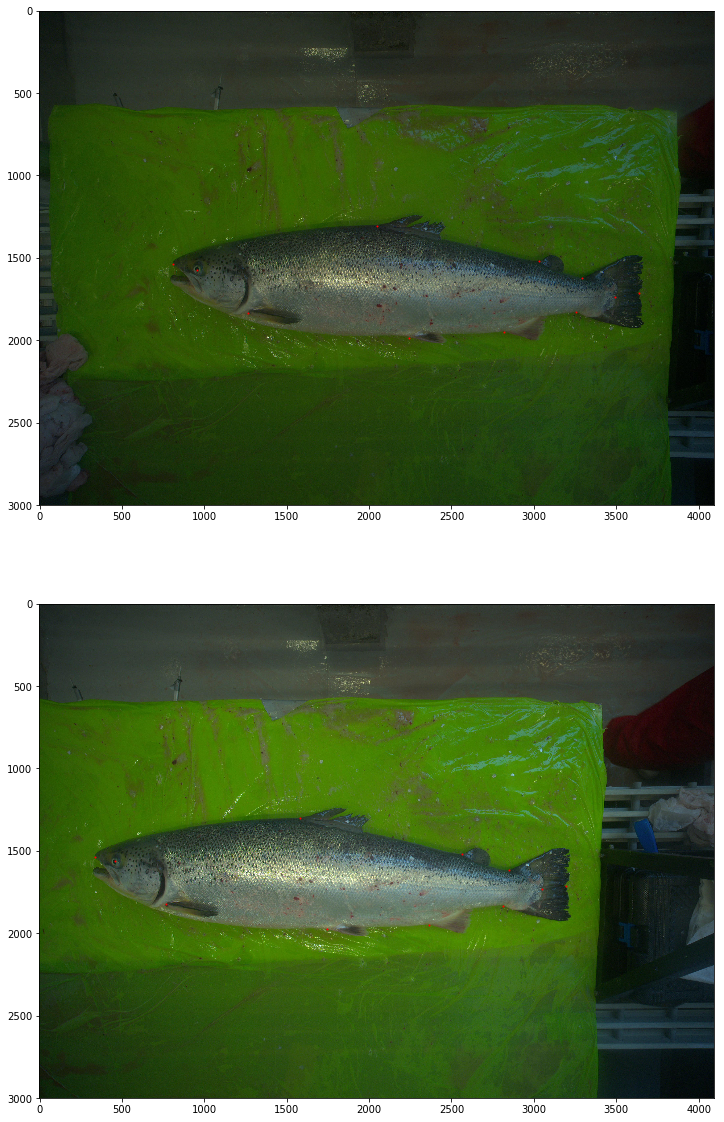

In [193]:
%matplotlib inline
v.load_data(649012)
v.display_crops(show_labels=False)

<IPython.core.display.Javascript object>


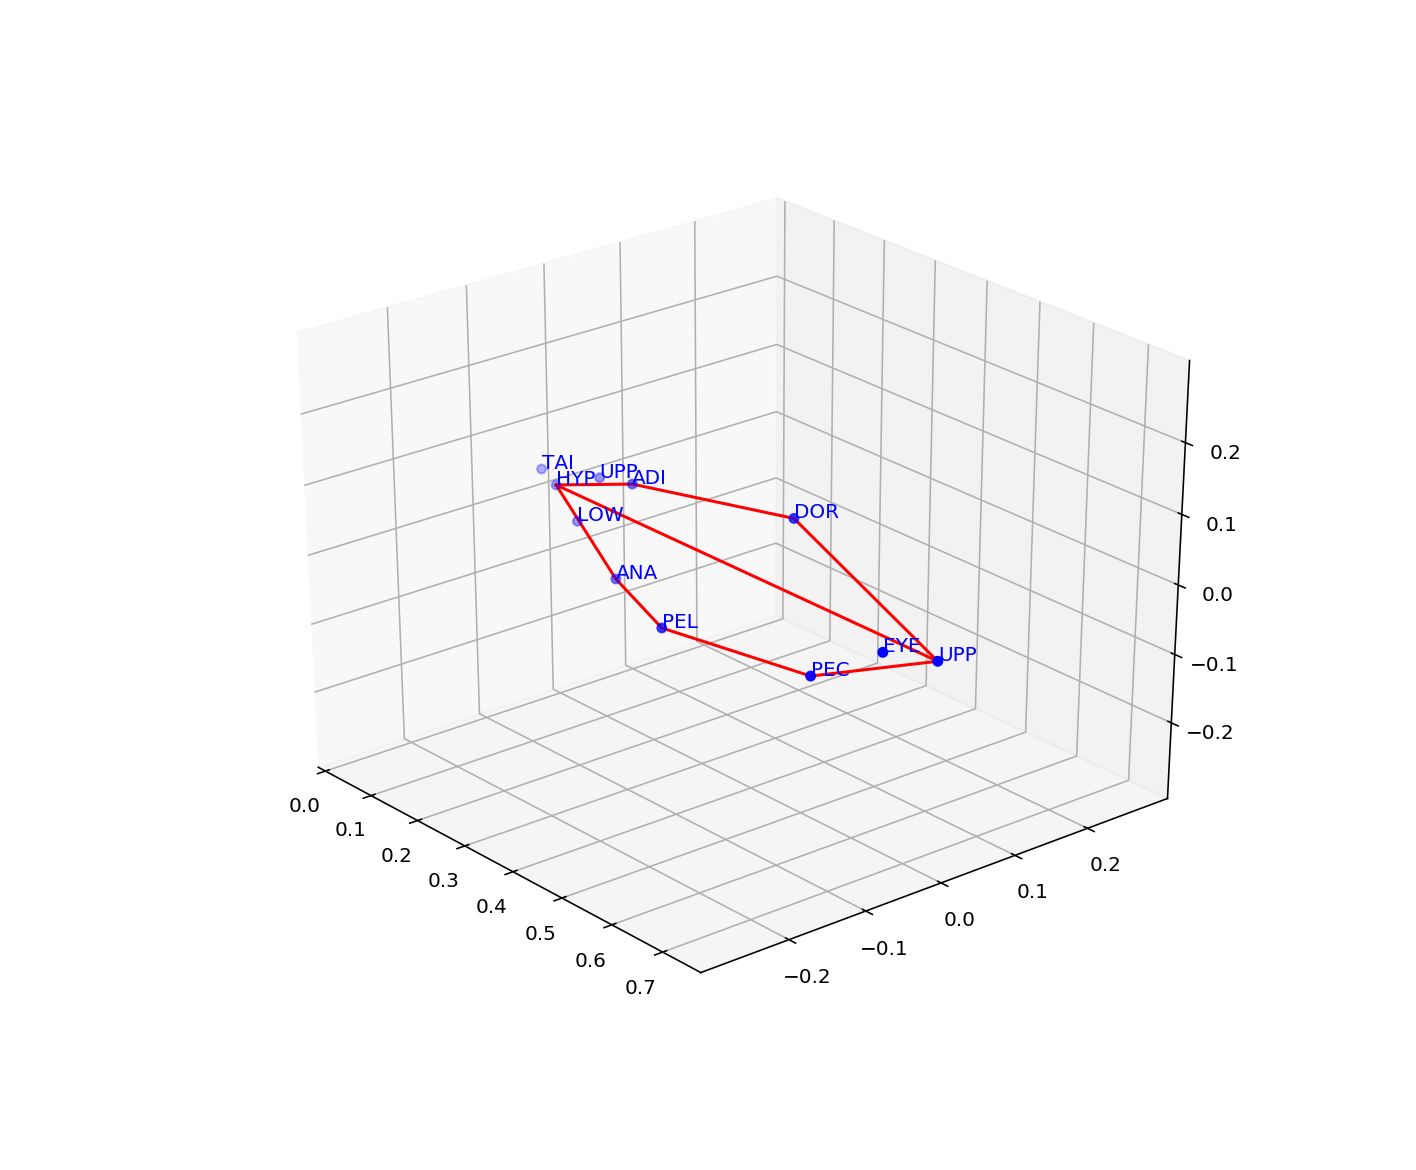

In [207]:
%matplotlib notebook
v.display_3d_keypoints()